In [8]:
# toc definitions
%matplotlib widget
import os
import ipywidgets as widgets
# import ipywidgets.widgets import interact
#os.environ['OPENBLAS_NUM_THREADS'] ='2'
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy
from scipy.io import loadmat
from scipy.io import savemat
import matplotlib.pyplot as plt
import pandas as pd
#import nest
import struct
import json
import sys
import seaborn as sns
from scipy import signal, stats
import subprocess
from src.data_proc.burst_detection import fixed_bursted_detection
na = np.array
sys.path.append("..") 
from src.helpers import *
# from src.data_proc.ephys_utils import pop_burst_detection
path1 = '/data/ovinogradov/ctx_03.04.22_Hertie/extracted_data/' + 'day18_potassium4.2_spikes2.csv'
path2 =  '/data/ovinogradov/ctx_14.03.22_Hertie/extracted_data/' + 'day17_potassium4.2_spikes.csv'


In [2]:
#%% 


# Well LABELS   
bic_label = ['A2','A3','A4','A5','A6',
            'B2','B3','B4','B5','B6']
control_label =['A1','B1','C1','D1']
standard_label = ['C2','C3','C4','C5','C6',
            'D2','D3','D4','D5','D6']

well_spikes= []
divs = [18,17]
div = []
wells = []
for i,file in enumerate([path1,path2]):
    data = pd.read_csv(file)
    for label in np.hstack([control_label,standard_label]):#standard_label,bic_label
            st = (data.filter(items=['Timestamp [µs]'])[data['Well Label']==label])*1e-6
            gid = data.filter(items=['Channel ID'])[data['Well Label']==label]
            well_spikes.append([na(st).T[0],na(gid).T[0]])
            div.append(divs[i])
            wells.append(label)
            

interactive(children=(Text(value='0', description='ind1'), Text(value='1', description='ind2'), FloatSlider(va…

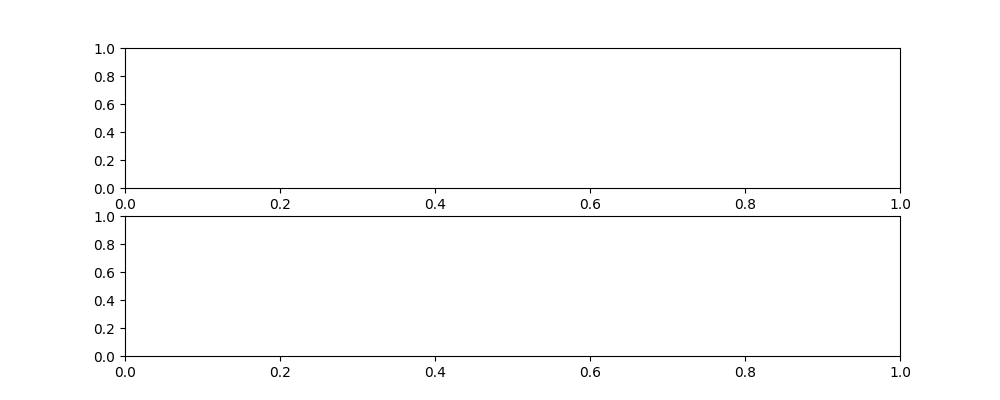

In [6]:
from src.helpers import  bimodality_index
from ipywidgets import interact                 
def get_slope(mibi,dur):
    p_up= dur/(mibi+dur)
    mean_x = p_up *9
    return mean_x

def gid_to_numbers(gid):
    for i,u_id in enumerate(np.unique(gid)):
        gid[gid==u_id]=i
    return gid
def dignostic_exclusion(data=None,
                        ax1=None,
                        method=None,
                        bi_thr=0.5,
                         isi_thr = 20,
                         minBdur=50,#100,
                         minIBI=1000,#1000,
                         minSburst=200,
                       
                       ):
    
        st = data[0]*1000
        gid = data[1]
        sc,times = np.histogram(st,np.arange(np.min(st),np.max(st),20.))
        # sc = sc/8
        gid = gid_to_numbers(na(gid))
        n_channels = np.max(gid)
        bursts = na(fixed_bursted_detection(st,gid,sc,
                                     bi_thr=bi_thr,
                                     isi_thr = isi_thr,
                                     minBdur=minBdur,
                                     minIBI=minIBI,
                                     minSburst=minSburst
                                     ))


        isi = np.diff(np.sort(st));
        bi = bimodality_index(sc)

        col = 'blue' 
        if len(bursts)>2:
            col = 'red'
            # valid[i] = 1
            for burst in bursts:
                ax1.axvspan(burst[0],burst[1],alpha=0.2,color ='g')
            ibis = bursts[1:,0]-bursts[:-1,1]
            durs = np.diff(bursts)
            mibi =np.mean(ibis)
            cvibi = np.std(ibis)/mibi
            mdur = np.mean(durs)
            cvdur = np.std(durs)/mdur
            burst_summary = [mibi,cvibi,mdur,cvdur]
        else:
            burst_summary = [np.nan,np.nan,np.nan,np.nan]   
    
        misi = np.mean(isi)
        # ax1.plot(st/1000,gid,'|',markersize=2.5)
        sc,times = np.histogram(st,np.arange(np.min(st),np.max(st),200.))
        slope = get_slope(burst_summary[0],burst_summary[2])
        ax1.plot(times[1:]/1000,sc/n_channels/0.2,color=col)
        ax1.set_xlim(0,400)
        
        values = ['Bimodality index: \n '+str(np.round(bi,4)),
                  'Median sc: \n '+str(np.median(sc)),
                  'burst CV \n'+str('{:f}'.format(np.round(burst_summary[1],2))),
                  'burst dur \n'+str('{:f}'.format(np.round(burst_summary[2],2))),
                  'ibi'+str('{:f}'.format(np.round(burst_summary[0],2))),
                  'slope'+str('{:f}'.format(np.round(slope,2))),
                 ]
        
        for i,string in enumerate(values):
            ax1.text(-0.15, .3+i*0.2, string, fontsize=8, 
                     transform=ax1.transAxes)#plt.gcf().transFigure)
        

fig, ax = plt.subplots(2,1,figsize=(10,4))
@interact( ind1='0', ind2='1',bi_thr=0.4,
             isi_thr_up = (0,1000,20),
             minBdur=(0,500,10),#100,
             minIBI=(0,5000,50),#1000,
             minSburst=(0,1000,5),
             perc=(0,100,.1))
def widget_excl(ind1=0,
                ind2=1,#246,
                bi_thr=0.4,
                isi_thr_up = 100,
                minBdur=50,#100,
                minIBI=1000,#1000,
                minSburst=100,
                perc = 90           
               ):
    
    ax[0].clear()
    ax[1].clear()

    
    st = well_spikes[int(ind1)][0]*1000
    st_s = np.mean(np.diff(np.sort(st)))#+np.std(np.diff(np.sort(st))) #np.percentile(np.diff(np.sort(st)),perc)
    isi_thr =min(max(st_s,50),500)#st_s#min(max(st_s,isi_thr),500)
    # display(st)
    display(st_s,isi_thr)
    

    count,_ = np.histogram(np.diff(st),[0,np.mean(np.diff(st))])

    display('count',count)

    dignostic_exclusion(well_spikes[int(ind1)],ax1=ax[0],
                               bi_thr=bi_thr,
                               isi_thr= isi_thr,
                               minBdur=minBdur,
                               minIBI=minIBI,
                               minSburst=minSburst);
    
    st = well_spikes[int(ind2)][0]*1000

    
    st_s = np.mean(np.diff(np.sort(st)))
    isi_thr =min(max(st_s,100),500)
    display(st_s,isi_thr)
    count,_ = np.histogram(np.diff(st),[0,np.mean(np.diff(st))])
    display(st)
    display('count',count)
    
    dignostic_exclusion(well_spikes[int(ind2)],ax1=ax[1],
                               bi_thr=bi_thr,
                               isi_thr= isi_thr,
                               minBdur=minBdur,
                               minIBI=minIBI,
                               minSburst=minSburst);
#     plt.show()

    return None

#                            bi_thr=0.4,#0.55,
#                            isi_thr = isi_thr,
#                            minBdur=50,#100,
#                            minIBI=500,#250,#1000,
#                            minSburst=45,

In [7]:
# Well LABELS   
bic_label = ['A2','A3','A4','A5','A6',
            'B2','B3','B4','B5','B6']
control_label =['A1','B1','C1','D1']
standard_label = ['C2','C3','C4','C5','C6',
            'D2','D3','D4','D5','D6']

def get_summary(data):
    st = data[0]*1000
    gid = data[1]
    sc,times = np.histogram(st,np.arange(np.min(st),np.max(st),200.))
    n_channels = 8
    sc = sc/n_channels
    perc = 95
    st_s = np.mean(np.diff(np.sort(st)))#+np.std(np.diff(np.sort(st))) #np.percentile(np.diff(np.sort(st)),perc)
#     isi_thr =min(max(st_s,100),500)#st_s#min(max(st_s,isi_thr),500)
    isi_thr =min(max(st_s,50),500)#st_s#min(max(st_s,isi_thr),500)
    
    mean_fr = len(st)/(np.max(st)/1000)
    mean_fr=mean_fr/n_channels
    
    bursts=  fixed_bursted_detection(st,gid,sc,
                           bi_thr=0.4,
                           isi_thr = isi_thr,
                           minBdur=50,#100,
                           minIBI=500,#1000,
                           minSburst=45,#minSburst#120,#120,
                           )
    if len(bursts)>2:#10
        ibis = bursts[1:,0]-bursts[:-1,1]
        durs = np.diff(bursts)
        mibi =np.mean(ibis)
        cvibi = np.std(ibis)/mibi
        mdur = np.mean(durs)
        cvdur = np.std(durs)/mdur
        r1 = np.corrcoef(ibis[:],durs[:-1,0])[0,1]
        r2 =np.corrcoef(ibis[:],durs[1:,0])[0,1]
        burst_summary = [mibi,cvibi,mdur,cvdur,r1,r2]
    else:
        burst_summary = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
    
    return mean_fr,burst_summary



In [46]:
def plot_activity(data):
    st = data[0]*1000
    gid = data[1]
    sc,times = np.histogram(st,np.arange(np.min(st),np.max(st),200.))
    n_channels = 8
    sc = sc/n_channels
    perc = 95
    st_s = np.mean(np.diff(np.sort(st)))#+np.std(np.diff(np.sort(st))) #np.percentile(np.diff(np.sort(st)),perc)
    isi_thr =min(max(st_s,50),500)#st_s#min(max(st_s,isi_thr),500)
    
    mean_fr = len(st)/(np.max(st)/1000)
    mean_fr=mean_fr/n_channels
    
    bursts=  fixed_bursted_detection(st,gid,sc,
                           bi_thr=0.4,
                           isi_thr = isi_thr,
                           minBdur=50,#100,
                           minIBI=500,#1000,
                           minSburst=45,#minSburst#120,#120,
                           )
    plt.plot(times[1:]/1000,sc)
    for burst in bursts:
        plt.axvspan(burst[0],burst[1],alpha=0.2,color ='g')
    plt.xlim([0,100])
    return None

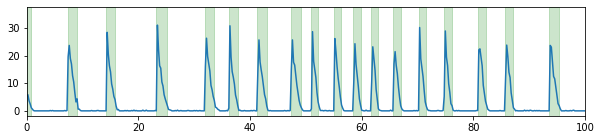

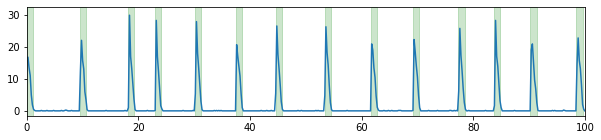

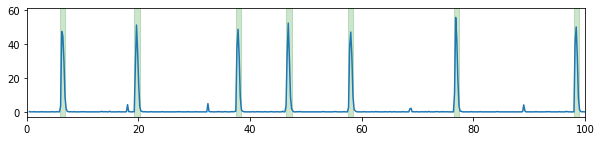

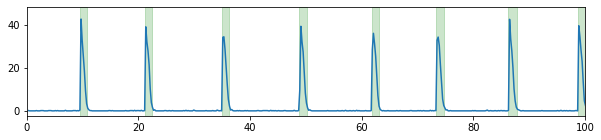

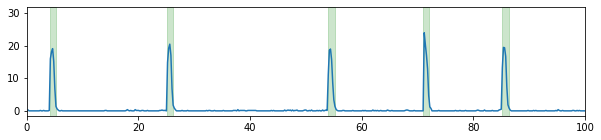

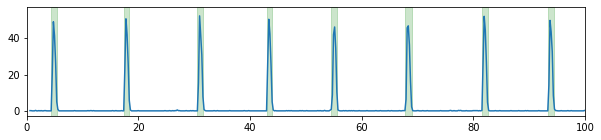

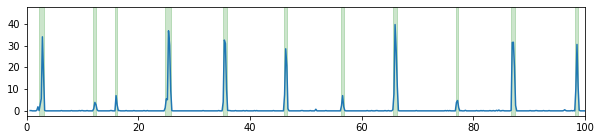

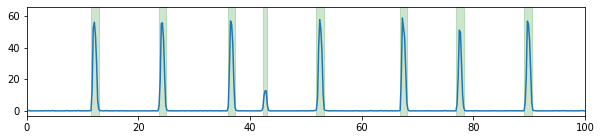

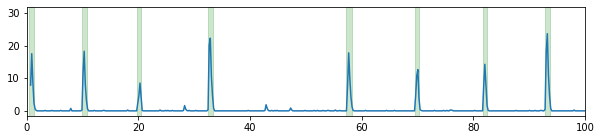

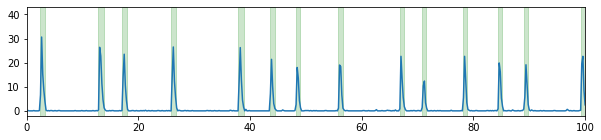

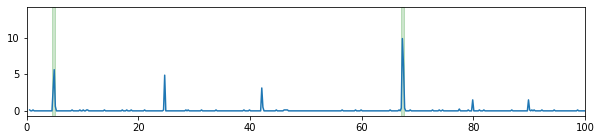

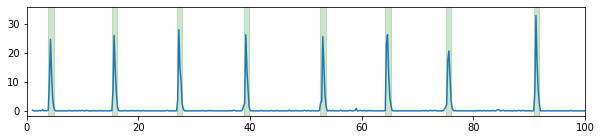

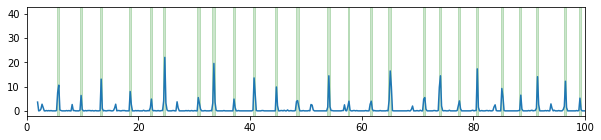

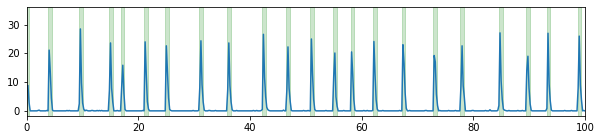

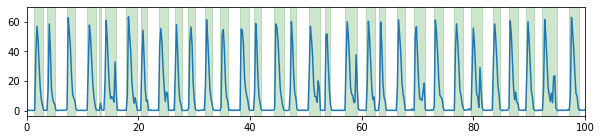

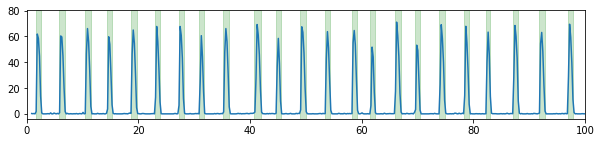

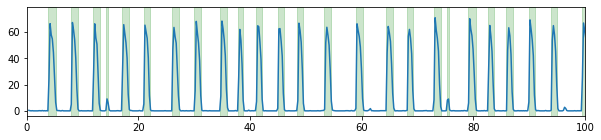

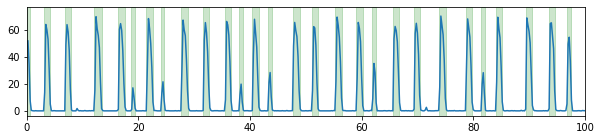

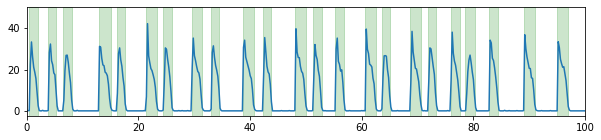

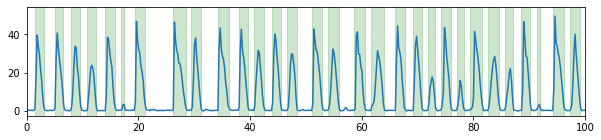

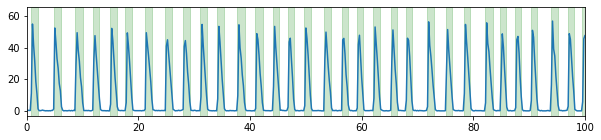

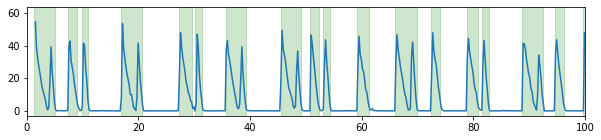

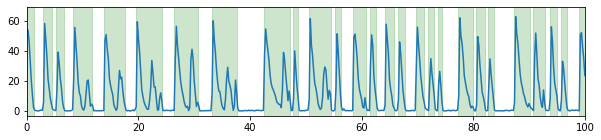

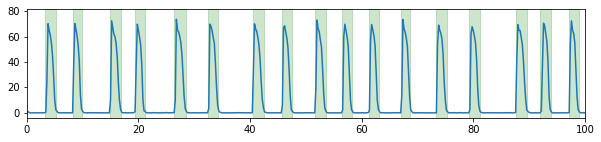

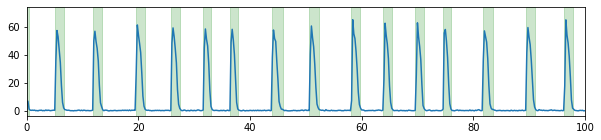

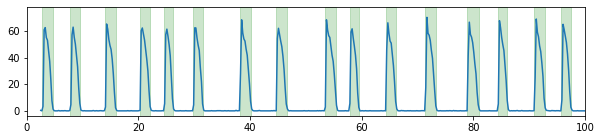

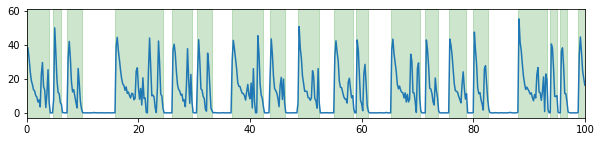

In [48]:
%matplotlib inline
plt.close()

<ipython-input-51-0ad6e266f308>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,2))


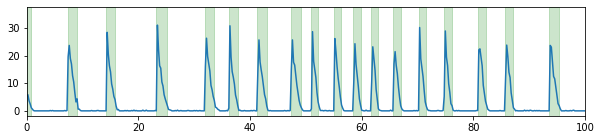

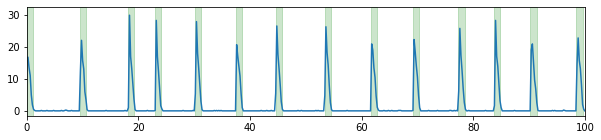

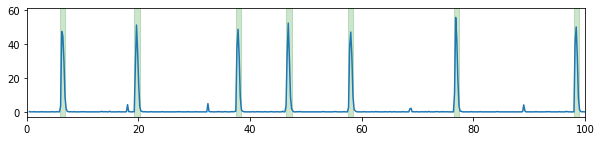

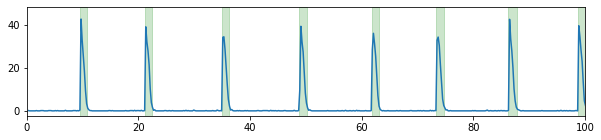

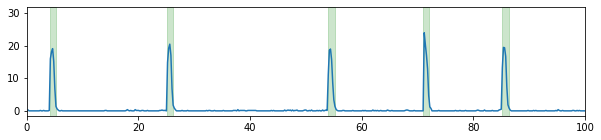

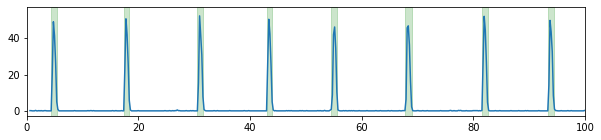

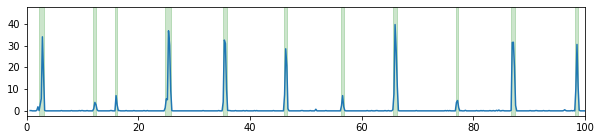

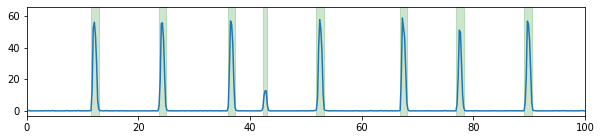

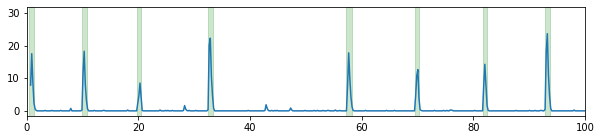

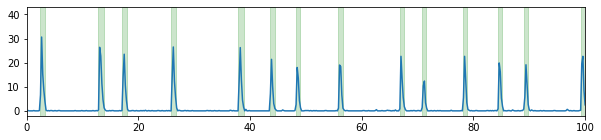

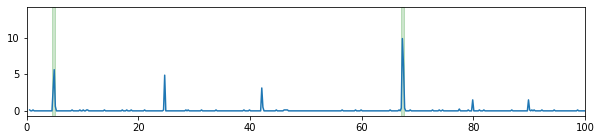

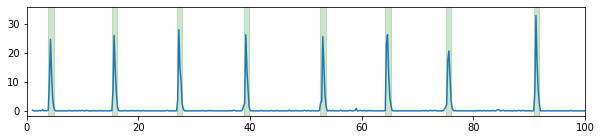

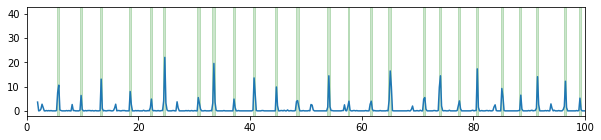

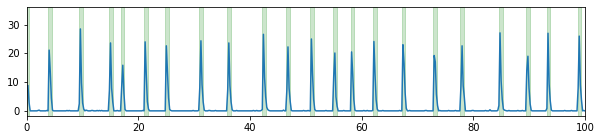

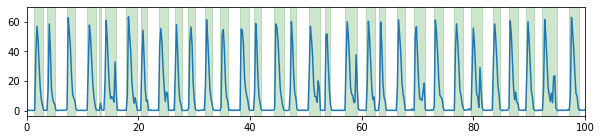

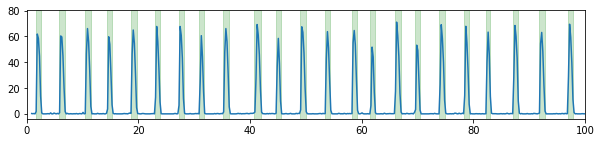

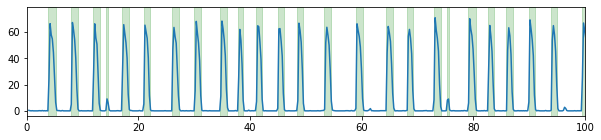

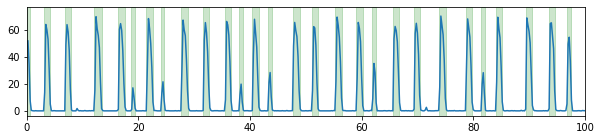

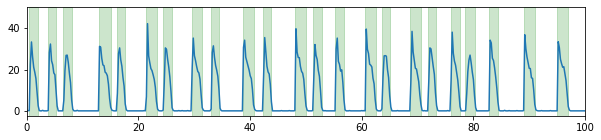

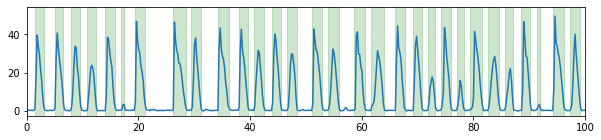

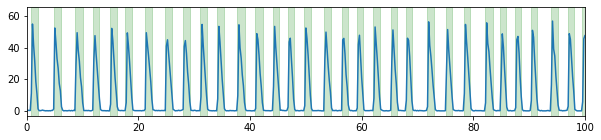

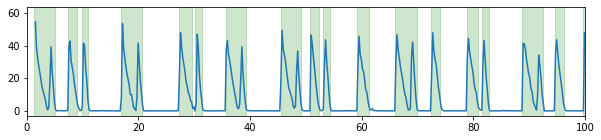

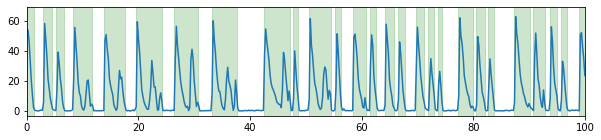

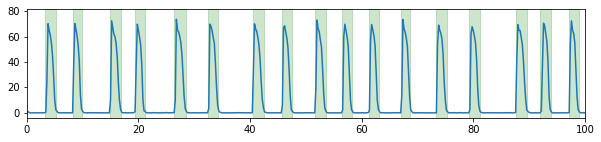

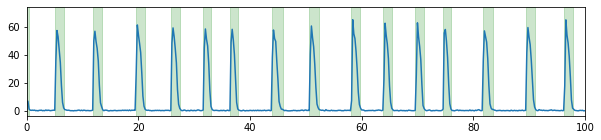

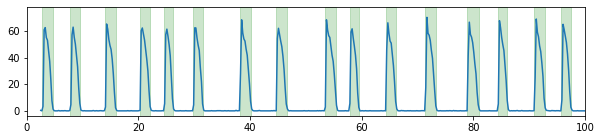

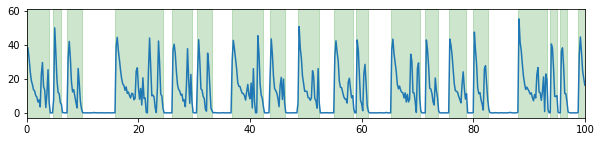

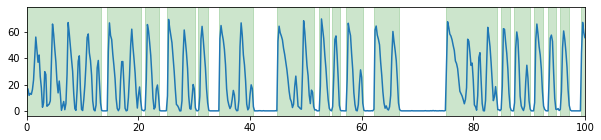

In [51]:
for i,data in enumerate(well_spikes[:]):
    plt.figure(figsize=(10,2))
    plot_activity(data)


In [9]:
summaries = []
mean_fr = []
for i,data in enumerate(well_spikes):
    fr,s = get_summary(data)
    summaries.append(s)
    mean_fr.append(fr)

In [10]:
cv1_data = na(summaries)[:,1]
cv2_data = na(summaries)[:,3]
ibi_data = na(summaries)[:,0]
dur_data = na(summaries)[:,2]
r1_data = na(summaries)[:,4]
r2_data = na(summaries)[:,5]
# r2_data = na(summaries)[:,5]
dat = pd.DataFrame(data={
                    'DIV':div,
                    # 'culture_type':culture_type,
                    'mea':wells,
                    'cvibi':cv1_data,
                    'cvdur':cv2_data,
                    'r1':r1_data,
                    'r2':r2_data,
                    'ibi':ibi_data,
                    'dur':dur_data,
                     'fr':mean_fr,
                    },)
def get_slope(mibi,dur):
    p_up= dur/(mibi+dur)
    mean_x = p_up *9
    return mean_x
dat['slope']=get_slope(dat['ibi'],dat['dur'])

In [18]:
dat.to_csv('../../data/CtxHipp/HIH_summary_full_v2024.csv')


(array([4., 8., 2., 2., 4., 2., 2., 1., 0., 3.]),
 array([0.15317769, 0.73707736, 1.32097703, 1.90487671, 2.48877638,
        3.07267605, 3.65657572, 4.2404754 , 4.82437507, 5.40827474,
        5.99217442]),
 <BarContainer object of 10 artists>)

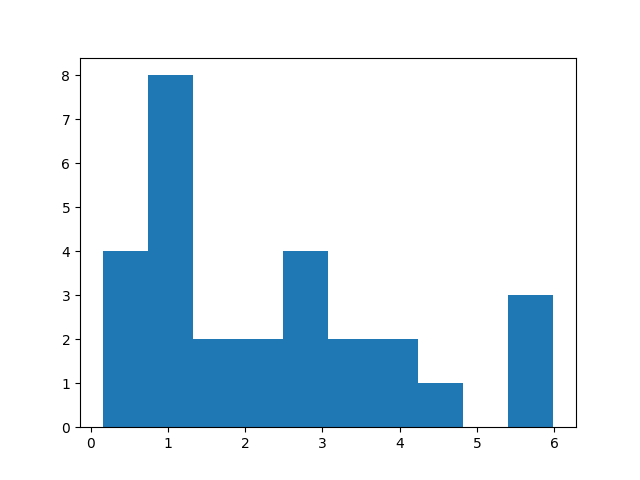

In [11]:
plt.figure()
# plt.hist(slopes)
plt.hist(dat['slope'])

<ErrorbarContainer object of 3 artists>

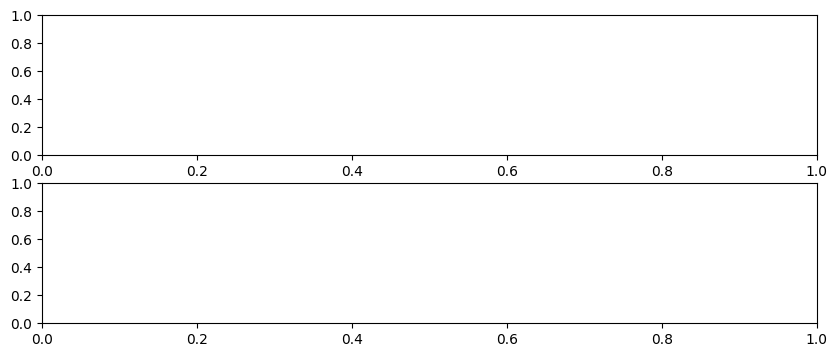

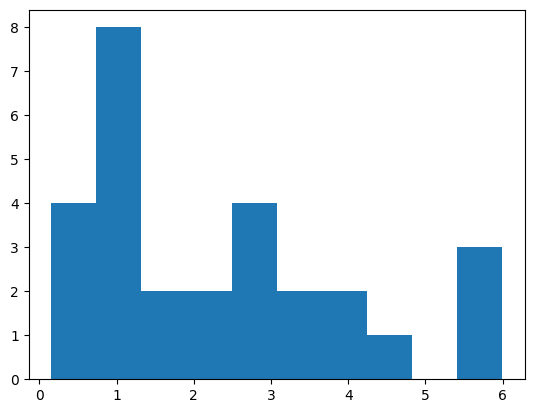

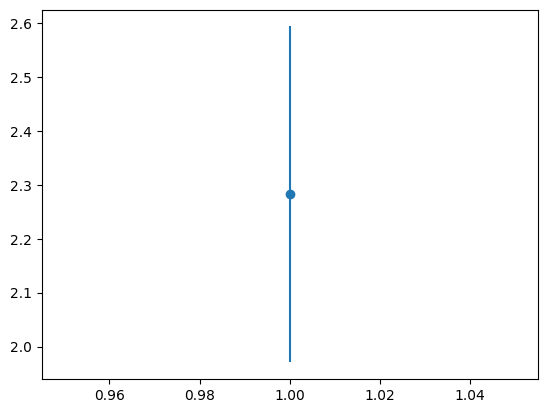

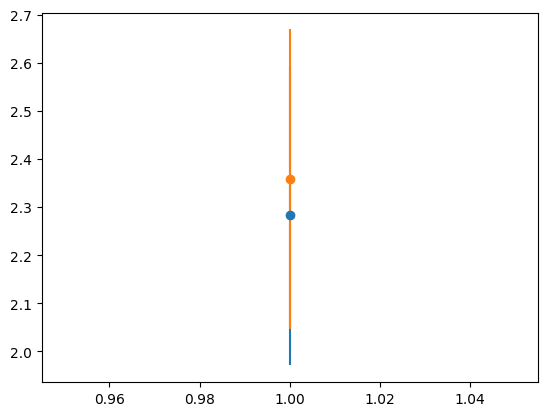

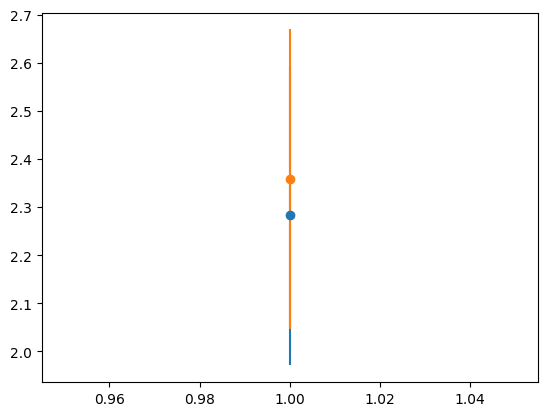

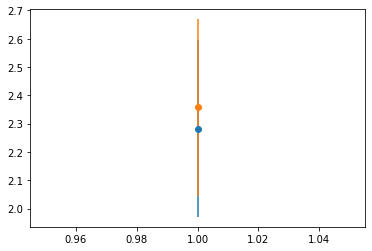

In [16]:
%matplotlib inline
plt.figure()
plt.errorbar(1,np.nanmean(dat['slope']),np.nanstd(dat['slope'])/np.sqrt(len(dat['slope'][np.isfinite(dat['slope'])])),fmt='o')
slopes = summ_ch['slope'][(summ_ch['culture_type']=='ctx')*(summ_ch['DIV']>24)]
plt.errorbar(1,np.nanmean(slopes),np.nanstd(slopes)/np.sqrt(len(slopes)),fmt='o')



In [13]:
summ_ch = pd.read_csv('../../data/CtxHipp/ctx_hipp_summary_full_single.csv') # Charleseworth
# '../data/CtxHipp/ctx_hipp_summary_full2.csv'
summ_ch['name'] = 'Charleseworth'
summ_ch.rename({'region':'culture_type'},axis=1,inplace=True)
summ_ch['culture_type'][summ_ch['culture_type']=="b'ctx'"] ='ctx'
summ_ch['culture_type'][summ_ch['culture_type']=="b'hpc'"] ='hipp'
summ_ch['slope']=get_slope(summ_ch['ibi'],summ_ch['dur'])
dat['slope']=get_slope(dat['ibi'],dat['dur'])

<ipython-input-13-db5be05cb0cc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_ch['culture_type'][summ_ch['culture_type']=="b'ctx'"] ='ctx'
<ipython-input-13-db5be05cb0cc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_ch['culture_type'][summ_ch['culture_type']=="b'hpc'"] ='hipp'


In [19]:

# Load spikes
import pickle


# # Open the file in binary read mode
# with open(file_path, 'rb') as file:
#     # Use pickle to load the object from the file
#     spks = pickle.load(file)



file_path = '../../data/CtxHipp/well_spikes_HIH_v2024'

# Open the file in write-binary mode and use pickle to dump the object
with open(file_path, 'wb') as file:
    pickle.dump(well_spikes, file)

# np.savemat(well_spikes)